### Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import shap # Pour l'interprétabilité (Bonus Senior)

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

### CHARGEMENT ET NETTOYAGE INITIAL

In [ ]:
# Remplacez par votre chemin réel
df = pd.read_csv('../../data/raw/train.csv') 

# Nettoyage des noms de colonnes (Snake Case) pour éviter les erreurs "KeyError"
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

# Définition de la cible et des features
target_col = 'heart_disease'

# Séparation X (Features) et y (Target)
X = df.drop(columns=['id', target_col]) # On enlève l'ID qui ne sert à rien
y = df[target_col]

# On transforme le texte en chiffres
# Vérifiez bien les majuscules : 'Absence' -> 0, 'Presence' -> 1
y = y.map({'Absence': 0, 'Presence': 1})

# Correction des types (Python a besoin de savoir quelles colonnes sont quoi)
# On identifie automatiquement les colonnes numériques et catégorielles
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Correction spécifique : Le Cholestérol à 0 est une erreur -> NaN
if 'cholesterol' in num_cols:
    X['cholesterol'] = X['cholesterol'].replace(0, np.nan)

print(f"Features Numériques ({len(num_cols)}) : {num_cols}")
print(f"Features Catégorielles ({len(cat_cols)}) : {cat_cols}")

# Split Train / Test (80% Train, 20% Test)
# stratify=y garantit qu'on a le même % de malades dans le train et le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Features Numériques (13) : ['age', 'sex', 'chest_pain_type', 'bp', 'cholesterol', 'fbs_over_120', 'ekg_results', 'max_hr', 'exercise_angina', 'st_depression', 'slope_of_st', 'number_of_vessels_fluro', 'thallium']
Features Catégorielles (0) : []


### 2. CONSTRUCTION DU PIPELINE

In [9]:
# Pipeline pour les variables numériques :
# 1. On remplit les trous (NaN) par la médiane
# 2. On met à l'échelle (StandardScaler) pour aider le modèle
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline pour les variables catégorielles :
# 1. On remplit les trous par la valeur la plus fréquente
# 2. One-Hot Encoding (Transforme "Sex" en "Sex_Male", "Sex_Female")
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# On combine les deux
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# LE MODÈLE FINAL : Preprocessing + XGBoost
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,       # Nombre d'arbres
        learning_rate=0.05,     # Vitesse d'apprentissage (plus petit = plus précis mais plus lent)
        max_depth=5,            # Profondeur des arbres
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

### 3. ENTRAÎNEMENT ET VALIDATION


In [10]:
print("\n🚀 Démarrage de l'entraînement...")
model.fit(X_train, y_train)
print("✅ Modèle entraîné avec succès !")

# Prédictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probabilité d'être malade



🚀 Démarrage de l'entraînement...


c:\Users\anase\Documents\Master_II\Langage R\Heart_attack\.venv\lib\site-packages\xgboost\training.py:200: UserWarning: [11:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modèle entraîné avec succès !


### 4. ÉVALUATION DES PERFORMANCES



--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     69509
           1       0.88      0.87      0.88     56491

    accuracy                           0.89    126000
   macro avg       0.89      0.89      0.89    126000
weighted avg       0.89      0.89      0.89    126000

🎯 SCORE AUC : 0.9560


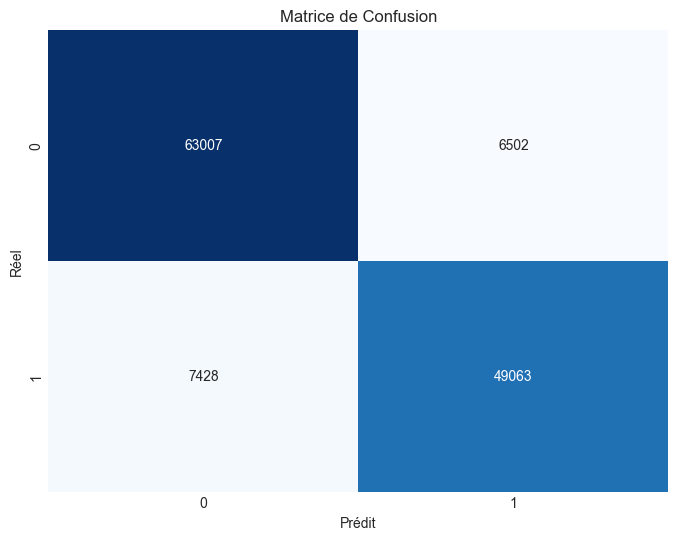

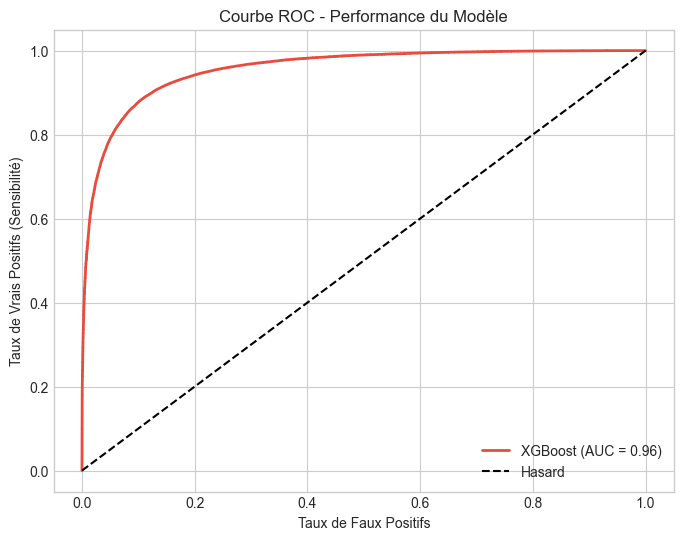

In [11]:
print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_test, y_pred))

# Calcul de l'AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"🎯 SCORE AUC : {auc_score:.4f}")

# Visualisation 1 : Matrice de Confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Visualisation 2 : Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})', color='#e74c3c', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Hasard')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Courbe ROC - Performance du Modèle')
plt.legend()
plt.show()

### 5. INTERPRÉTATION (BONUS SENIOR : SHAP)


In [12]:
import shap
import xgboost as xgb
import os
import matplotlib.pyplot as plt

print("🔍 Démarrage de l'analyse SHAP...")

# --- ÉTAPE 1 : Nettoyage du modèle pour compatibilité SHAP ---
# On sauvegarde et recharge le modèle pour forcer un format propre
temp_model = "temp_shap_model.json"
model.named_steps['classifier'].save_model(temp_model)

# On recharge dans un booster vierge
booster = xgb.Booster()
booster.load_model(temp_model)

# On force le paramètre base_score à être un simple chiffre (et pas une liste)
booster.set_param({"base_score": 0.5})
print("✅ Modèle rendu compatible avec SHAP.")

# --- ÉTAPE 2 : Préparation des données ---
# On transforme X_test en chiffres via le pipeline (SHAP ne veut pas de texte)
X_test_processed = model.named_steps['preprocessor'].transform(X_test)

# Récupération des noms de colonnes
if len(cat_cols) > 0:
    cat_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols).tolist()
else:
    cat_names = []
feature_names = num_cols + cat_names

# --- ÉTAPE 3 : Calcul et Affichage ---
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_processed)

# Nettoyage du fichier temporaire
if os.path.exists(temp_model):
    os.remove(temp_model)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, plot_type="bar")
plt.show()

🔍 Démarrage de l'analyse SHAP...
✅ Modèle rendu compatible avec SHAP.


ValueError: could not convert string to float: '[5E-1]'